# Реализация нахождения уравнений движения с помощью Урванений Татаринова 

##### TODO 
 - Добавить рисунок и описание решаемой здесь задачи
 - Добавить решение с помощью общих теорем динамики
 - Тесты

In [1]:
import sympy as sp
from sympy import Derivative, Symbol, IndexedBase, Eq, Idx, Sum, Function, Matrix, Add
from sympy import diff, symbols, solve, simplify, poly, pprint, factor, integrate, lambdify
from sympy import cos, sin, pi

from abc import ABC, abstractmethod

### Уравнения Татаринова
$$
\frac{d}{dt} \frac{\partial L*}{\partial \omega_{\alpha}} +
\{P_{\alpha}, L*\} = 
\{P_{\alpha}, \sum_{\mu}{\omega_{\mu} P_{\mu}} \} +
\sum_{i}{Q_i \frac{\partial v_i}{ \partial \omega_{\alpha}}}
$$

### Скобка Пуассона
$$
\{f, g\} = \sum_{i=1}^{N} \left( \frac{\partial f}{\partial q_{i}} \frac{\partial g}{\partial p_{i}} - \frac{\partial f}{\partial p_i} \frac{\partial g}{\partial q_i}\right).
$$

### Функции $ P_{\alpha} $
$$
\sum_{\alpha}{P_{\alpha} \omega_{\alpha}} = \sum_i{p_iv_i}
$$

### Функции $v_i$
$$
v_i = \dot{q}
$$

In [2]:
class MechanicalSystem():
    
    def __init__(self):
        pass
    
    def set_q(self, q):
        self.q = q
    
    def set_p(self, p):
        self.p = p
    
    def poisson_bracket(self, F, G): # надо сделать, чтобы использовалось IndexedBase
        """ To evaluate an unevaluated derivative, use the doit method. """
        res = 0
        for i in range(3):
            res += diff(F, self.q[i])*diff(G, self.p[i])
            res -= diff(F, self.p[i])*diff(G, self.q[i])
        return res
    
    @staticmethod
    def sub_Eq(equation, Eq):
        return equation.subs(Eq.args[0], Eq.args[1])
    
    @classmethod
    def sub_Eqs(cls, equation, Eqs):
        sub_equation = equation
        for Eq in Eqs:
            sub_equation = cls.sub_Eq(sub_equation, Eq)
        return sub_equation 
    
    @staticmethod
    def left_part_Eqs(Eqs):
        return [Eq.args[0] for Eq in Eqs]
    
    @staticmethod
    def right_part_Eqs(Eqs):
        return [Eq.args[1] for Eq in Eqs]
    
    def set_constraints(self, constraints):
        """ Setting up constraints """
        self.constraints = constraints
        
    def sub_constraints(self, func):
        """ Substitutes constraints in the equation
        Private special case:
            L -> L* 
        """
        sub_dict = {conn.args[0]: conn.args[1] for conn in self.constraints}
        return func.subs(sub_dict)
    
    def sub_constraints_to_list(self, equations):
        return [self.sub_constraints(equation) for equation in equations]
    
    @staticmethod
    def diff_hack(equation, by):
        """ eq -> eq.subs(Derivative -> temp_variable) -> eq.diff(temp_variable) ->
            -> eq.subs(temp_variable -> Derivative)
        """
        tmp_by = Symbol('tmp_by')
        tmp_eq = equation.subs({by: tmp_by})
        tmp_eq = tmp_eq.diff(tmp_by)
        return tmp_eq.subs({tmp_by: by})
        

In [3]:
class TatarinovSystem(MechanicalSystem):
    
    def __init__(self, N=3):
        super().__init__()
        self.N = N
        self.tatarinov_equations = [None]*N
        
    def set_omega_equations(self, omegas, equations):
        omega_equations = [Eq(omega, equation) for omega, equation in zip(omegas, equations)]
        self.omega_equations = omega_equations
        
    def set_v_equations(self, vs, equations): # vs - не лучшее название
        v_equations = [Eq(v, equation) for v, equation in zip(vs, equations)]
        self.v_equations = v_equations

    def set_P(self):
        k, mu = symbols('k, mu', cls=Idx)
        left = Sum(P[k]*om[k], (k, 1, self.N)).doit()
        right = Sum(p[i]*v[i], (k, 1, self.N))
        Eq(left, right)
    
    def set_L(self, L):
        self.L = L
    
    def set_F(self, F):
        self.F = F
    
    def create_r(self):
        r = {}
        r['s'] = x*e['x'] + y*e['y']
        r['p'] = r['s'] + xi*e['xi'] + eta*e['eta']
        self.r = r
        return self.r

    def set_Qs(self, Qs):
        self.Qs = Qs
    
    def create_P(self):
        equations_for_P = Eq(
            Sum(P[k]*omega[k], (k, 1, S.N)),
            Sum(p[k]*v[k], (k, 1, S.N)))
        print(equations_for_P)
        # subs omega_i and v_i
        sub_equations_for_P = TatarinovSystem.sub_Eqs(
            equations_for_P.doit(), # important
            self.omega_equations + self.v_equations) # for Ex: omega[1] -> nu1), v[1] -> x', ....
        # subs_constraints
        sub_conn_equations_for_P = self.sub_constraints(sub_equations_for_P)
        print(sub_conn_equations_for_P)
        # to equate the coefficients
        left_coeffs = poly(sub_conn_equations_for_P.args[0], TatarinovSystem.right_part_Eqs(self.omega_equations)).coeffs()
        right_coeffs = poly(sub_conn_equations_for_P.args[1], TatarinovSystem.right_part_Eqs(self.omega_equations)).coeffs()
        final_equations_for_P = [Eq(left, right) for left, right in zip(left_coeffs, right_coeffs)]
        self.Ps = final_equations_for_P
        return final_equations_for_P
    
    def create_Q(self, F, r_p):
        self.Q = [F.dot(r_p.diff(x)) for x in self.q]
    
    def Q_dw_by_dv(self, i):
        Q_dw_by_dv = lambda i,a: self.Q[i]*Derivative(self.right_part_Eqs(S.sub_constraints_to_list(S.v_equations))[i],
                                                      self.right_part_Eqs(self.omega_equations)[a]).doit()
        Q_dw_by_dv_sum = lambda a: Q_dw_by_dv(0,a) + Q_dw_by_dv(1,a) + Q_dw_by_dv(2,a)
        return Q_dw_by_dv_sum(i)
    
    def tatarinov_equation__depricated(self, i):
        left, right = 0, 0;
        left += diff(diff(L, omega[k]), t)
        left += poisson_bracket(P[k], L)
        right += poisson_bracket(P[k], Sum(omega[k]*P[k], (k, 1, self.N)))
        right += Sum(Q[l]*diff(v[l], omega[k]), (l, 1, self.N))
        Eq(left, right)
        
    def create_bracket_sum(self):
        """ not good """
        return  nu1*(p[1]*cos(alpha) + p[2]*sin(alpha)) + nu2*(-p[1]*sin(alpha) + p[2]*cos(alpha)) + nu3*p[3]
        bracket_sum = [x*y for x,y in zip(S.right_part_Eqs(S.Ps), S.right_part_Eqs(S.omega_equations))]
        res = 0
        for x in range(3):
            res += bracket_sum[x]
        return res
    
    def create_fs(self, fs):
        """ not good """
        nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
        return fs.subs({
            nu1: Function('nu1')(t),
            nu2: Function('nu2')(t),
            nu3: Function('nu3')(t)
        })
    
    def create_ss(self, fs):
        """ not good """
        nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
        return fs.subs({
            Function('nu1')(t): nu1,
            Function('nu2')(t): nu2,
            Function('nu3')(t): nu3
        })
    
    def solve_tatarinov_equations(self):
        te = [self.tatarinov_equations[i] for x in range(3)]
        sol = solve(te, [Derivative(self.create_fs(x), t) for x in S.right_part_Eqs(S.omega_equations)])
        return sol

    def tatarinov_equation(self, i):
        left, right = 0,0
        left = S.sub_constraints(self.L).args[1]
        left = self.create_fs(left.diff(self.right_part_Eqs(self.omega_equations)[i])).diff(t)
        left += self.poisson_bracket(self.Ps[i].args[1], self.sub_constraints(self.L).args[1])
        left = self.create_fs(left)
#         display(left)
        
        right += self.poisson_bracket(self.Ps[i].args[1], self.create_bracket_sum())
        right += simplify(self.Q_dw_by_dv(i))
        right = self.create_fs(right)
#         display(right)
        
        ps = lambda i: self.sub_constraints(self.diff_hack(self.L.args[1], self.right_part_Eqs(self.v_equations)[i]))
        self.tatarinov_equations[i] = Eq(left, right).subs({p[1]: ps(0), p[2]: ps(1), p[3]: ps(2)})
        
        self.tatarinov_equations[i] = self.create_fs(simplify(self.tatarinov_equations[i]))
        
        return self.tatarinov_equations[i]

    def display_tatarinov_equations(self):
        for eq in self.tatarinov_equations:
            display(eq)

In [4]:
L, m, x, y, t, alpha = symbols('L, m, x, y, t, alpha')
nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
W, T = symbols('W, T')
s = symbols('s')
P = IndexedBase('P')
p = IndexedBase('p')
omega = IndexedBase('omega')
v = IndexedBase('v')
Q = IndexedBase('Q')
k = symbols('k', cls=Idx)
J = IndexedBase('J')

xi, eta = symbols('xi, eta')
e = {}
e['x'] = Matrix([1,0])
e['y'] = Matrix([0,1])
e['xi'] = Matrix([cos(alpha), sin(alpha)])
e['eta'] = Matrix([-sin(alpha), cos(alpha)])

In [5]:
A, C, c = symbols('A, C, c')

psi, theta, phi = symbols('psi, theta, phi') # v

g = symbols('g')

### Определим Лагранжиан

In [6]:
L = Eq(L, m*(Derivative(x,t)**2 + Derivative(y,t)**2)/2 + J[s]*(Derivative(alpha, t)**2)/2)
L

Eq(L, m*(Derivative(x, t)**2 + Derivative(y, t)**2)/2 + Derivative(alpha, t)**2*J[s]/2)

### Определим связи 

In [7]:
conn1 = Eq(Derivative(x,t), cos(alpha)*nu1 - sin(alpha)*nu2)
conn2 = Eq(Derivative(y,t), sin(alpha)*nu1 + cos(alpha)*nu2)
conn3 = Eq(Derivative(alpha,t), nu3)

In [8]:
display(conn1)
display(conn2)
display(conn3)

Eq(Derivative(x, t), nu1*cos(alpha) - nu2*sin(alpha))

Eq(Derivative(y, t), nu1*sin(alpha) + nu2*cos(alpha))

Eq(Derivative(alpha, t), nu3)

### Создадим объект для механической системы с уравнениями Татаринова 

In [9]:
S = TatarinovSystem()

### Заполним что нужно (связи, уравнения для $\omega_i$, $v_i$, $F$)

In [10]:
S.set_L(L)

In [11]:
S.set_p([p[1], p[2], p[3]]) # это скорее внутренняя переменная и её не надо задавать
S.set_q([x, y, alpha])

In [12]:
S.set_constraints([conn1, conn2, conn3])
S.constraints

[Eq(Derivative(x, t), nu1*cos(alpha) - nu2*sin(alpha)),
 Eq(Derivative(y, t), nu1*sin(alpha) + nu2*cos(alpha)),
 Eq(Derivative(alpha, t), nu3)]

In [13]:
S.set_omega_equations(omegas=[omega[1], omega[2], omega[3]],
                      equations=[nu1, nu2, nu3])
S.omega_equations

[Eq(omega[1], nu1), Eq(omega[2], nu2), Eq(omega[3], nu3)]

In [14]:
S.set_v_equations(vs=[v[1], v[2], v[3]],
                  equations=[Derivative(x,t), Derivative(y,t), Derivative(alpha,t)])
S.v_equations

[Eq(v[1], Derivative(x, t)),
 Eq(v[2], Derivative(y, t)),
 Eq(v[3], Derivative(alpha, t))]

In [15]:
F = W*e['xi'] + T*e['eta']
S.set_F(F)
F

Matrix([
[-T*sin(alpha) + W*cos(alpha)],
[ T*cos(alpha) + W*sin(alpha)]])

### Создадим $P_{\alpha}$

In [16]:
Ps = S.create_P()
Ps

Eq(Sum(P[k]*omega[k], (k, 1, 3)), Sum(p[k]*v[k], (k, 1, 3)))
Eq(nu1*P[1] + nu2*P[2] + nu3*P[3], nu3*p[3] + (nu1*sin(alpha) + nu2*cos(alpha))*p[2] + (nu1*cos(alpha) - nu2*sin(alpha))*p[1])


[Eq(P[1], sin(alpha)*p[2] + cos(alpha)*p[1]),
 Eq(P[2], -sin(alpha)*p[1] + cos(alpha)*p[2]),
 Eq(P[3], p[3])]

### Получение $Q_i$

In [17]:
S.create_Q(S.F, S.create_r()['p'])
S.Q

[-T*sin(alpha) + W*cos(alpha),
 T*cos(alpha) + W*sin(alpha),
 (-T*sin(alpha) + W*cos(alpha))*(-eta*cos(alpha) - xi*sin(alpha)) + (T*cos(alpha) + W*sin(alpha))*(-eta*sin(alpha) + xi*cos(alpha))]

### $ L^* $

In [18]:
simplify(S.sub_constraints(L))

Eq(L, m*(nu1**2 + nu2**2)/2 + nu3**2*J[s]/2)

### Получаем уравнения

In [19]:
for i in range(3):
    S.tatarinov_equation(i)

In [20]:
S.tatarinov_equations

[Eq(W + m*nu2(t)*nu3(t), m*Derivative(nu1(t), t)),
 Eq(m*Derivative(nu2(t), t), T - m*nu1(t)*nu3(t)),
 Eq(Derivative(nu3(t), t)*J[s], T*xi - W*eta)]

In [21]:
for eq in S.tatarinov_equations:
    display(eq)

Eq(W + m*nu2(t)*nu3(t), m*Derivative(nu1(t), t))

Eq(m*Derivative(nu2(t), t), T - m*nu1(t)*nu3(t))

Eq(Derivative(nu3(t), t)*J[s], T*xi - W*eta)

## Найдем  $W,T, \ddot{\alpha}$  как функции от времени 

In [22]:
from copy import copy

for x in S.tatarinov_equations:
    display(x)

Eq(W + m*nu2(t)*nu3(t), m*Derivative(nu1(t), t))

Eq(m*Derivative(nu2(t), t), T - m*nu1(t)*nu3(t))

Eq(Derivative(nu3(t), t)*J[s], T*xi - W*eta)

### Зададим $x,y, alpha$ как функции времени

In [23]:
# Начальные условия и парметры
eq_x = 3*t
eq_y = t**2

params = dict(xi=0, eta=0)

t_end = 2*pi.evalf()

In [24]:
def _ss(eq):
    nu1, nu2, nu3 = symbols('nu1, nu2, nu3')
    return eq.subs({
        nu1: Function('nu1')(t),
        nu2: Function('nu2')(t),
        nu3: Function('nu3')(t)
    })
    
def subs_funcs(eq):
    subs_dict = dict(x=eq_x, y=eq_y, alpha=Function('alpha')(t)) # , alpha=eq_alpha)
    if type(eq) == dict:
        d = {}
        for k,v in eq.items():
            d[_ss(k)] = _ss(v.subs(subs_dict))
        return d
    if type(eq) == list:
        l = []
        for x in eq:
            l += _ss(eq.subs(subs_dict))
        return l
    if type(eq) == Eq or type(eq) == Add:
        return _ss(eq.subs(subs_dict))

In [25]:
S.constraints

[Eq(Derivative(x, t), nu1*cos(alpha) - nu2*sin(alpha)),
 Eq(Derivative(y, t), nu1*sin(alpha) + nu2*cos(alpha)),
 Eq(Derivative(alpha, t), nu3)]

In [26]:
nus = solve(S.constraints, S.right_part_Eqs(S.omega_equations))
for k, v in nus.items():
    display(Eq(k, v))

Eq(nu1, sin(alpha)*Derivative(y, t) + cos(alpha)*Derivative(x, t))

Eq(nu2, -sin(alpha)*Derivative(x, t) + cos(alpha)*Derivative(y, t))

Eq(nu3, Derivative(alpha, t))

In [27]:
nust = subs_funcs(nus)
nust

{nu1(t): sin(alpha(t))*Derivative(t**2, t) + cos(alpha(t))*Derivative(3*t, t),
 nu2(t): -sin(alpha(t))*Derivative(3*t, t) + cos(alpha(t))*Derivative(t**2, t),
 nu3(t): Derivative(alpha(t), t)}

In [28]:
tet = copy(S.tatarinov_equations)
for x in tet:
    display(x)

Eq(W + m*nu2(t)*nu3(t), m*Derivative(nu1(t), t))

Eq(m*Derivative(nu2(t), t), T - m*nu1(t)*nu3(t))

Eq(Derivative(nu3(t), t)*J[s], T*xi - W*eta)

In [29]:
for i in range(3):
    tet[i] = tet[i].subs(nust).doit()
    display(tet[i])
#     display((tet[i].subs(nust)))
#     display((tet[i].subs(nust)).doit())
    

Eq(W + m*(2*t*cos(alpha(t)) - 3*sin(alpha(t)))*Derivative(alpha(t), t), m*(2*t*cos(alpha(t))*Derivative(alpha(t), t) - 3*sin(alpha(t))*Derivative(alpha(t), t) + 2*sin(alpha(t))))

Eq(m*(-2*t*sin(alpha(t))*Derivative(alpha(t), t) - 3*cos(alpha(t))*Derivative(alpha(t), t) + 2*cos(alpha(t))), T - m*(2*t*sin(alpha(t)) + 3*cos(alpha(t)))*Derivative(alpha(t), t))

Eq(Derivative(alpha(t), (t, 2))*J[s], T*xi - W*eta)

In [30]:
sol = solve(tet, [T, W, Derivative(Function('alpha')(t), t, 2)])
for k,v in sol.items():
    display(Eq(k, v))

Eq(T, 2*m*cos(alpha(t)))

Eq(W, 2*m*sin(alpha(t)))

Eq(Derivative(alpha(t), (t, 2)), 2*m*(-eta*sin(alpha(t)) + xi*cos(alpha(t)))/J[s])

### Проинтегрируем
$$ {\ddot{\alpha}, \dot{\alpha}} \rightarrow \alpha $$

In [31]:
_vars = [Function('alpha2')(t), Function('alpha')(t)]
_vars

[alpha2(t), alpha(t)]

In [32]:
eqs = [Function('alpha2')(t), list(sol.values())[2]]
eqs

[alpha2(t), 2*m*(-eta*sin(alpha(t)) + xi*cos(alpha(t)))/J[s]]

In [33]:
_vars = [Symbol('alpha'),  Symbol('alpha2')]
eqs =   [Symbol('alpha2'), list(sol.values())[2].subs({Function('alpha')(t): Symbol('alpha')})]

print("Система уравнений на alpha")
for l, r in zip(_vars, eqs):
    display(Eq(l,r))

Система уравнений на alpha


Eq(alpha, alpha2)

Eq(alpha2, 2*m*(-eta*sin(alpha) + xi*cos(alpha))/J[s])

In [34]:
# keyword can't be an expression
eqs[1] = eqs[1].subs({J[s]: 3})

_subs = dict(m=1, eta=2, xi=3)

In [35]:
def f(_vars_values, time):
    return [lambdify(_vars, x.subs(_subs), 'numpy')(*_vars_values) for x in eqs]

In [36]:
import numpy as np
from scipy.integrate import RK45, odeint

In [37]:
f0 = [1, 0.1] # [alpha', alpha]
time = np.linspace(0., 4, 100)

_solution = odeint(f, f0, time)

dot_alpha


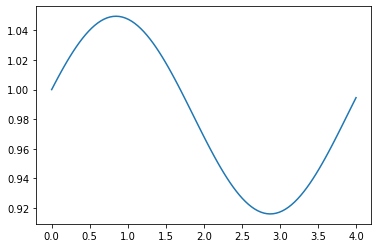

alpha


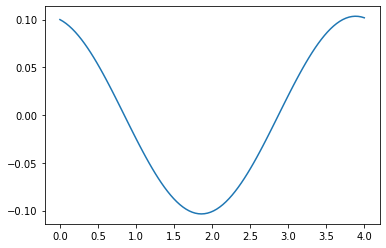

In [39]:
import matplotlib.pyplot as plt

_items = zip(['dot_alpha', 'alpha'], list(range(2)))

for name, col in _items:
    print(name)
    fig = plt.plot(time, _solution[:, col], label=name)
    plt.show()

## Подставим в $W, T$
$$ \{W(\alpha, t), T(\alpha, t)\} \rightarrow \{W(t), T(t)\}$$

In [40]:
display(sol[W])
display(sol[T])

2*m*sin(alpha(t))

2*m*cos(alpha(t))

In [41]:
W_t = lambdify([t, Function('alpha')(t)], sol[W].subs(_subs), 'numpy')
T_t = lambdify([t, Function('alpha')(t)], sol[T].subs(_subs), 'numpy')

In [42]:
_solution[:,1].size == time.size 

True

In [43]:
wl, tl = [], []

for x,y in zip(time, _solution[:,1]):
    wl.append(W_t(x, y))
    
for x,y in zip(time, _solution[:,1]):
    tl.append(T_t(x, y))

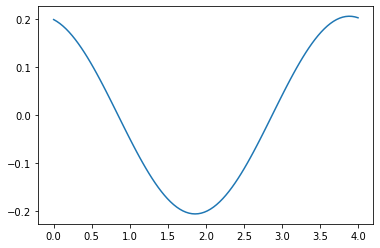

In [44]:
fig = plt.plot(time, wl, label='W')
plt.show()

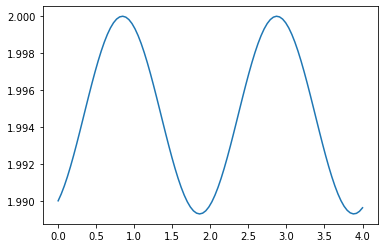

In [45]:
fig = plt.plot(time, tl, label='T')
plt.show()

In [49]:
al = _solution[:, 1]

In [58]:
tmp_x = tl*np.sin(al)*(-1) + wl*np.cos(al)
tmp_y = tl*np.cos(al) + wl*np.sin(al)

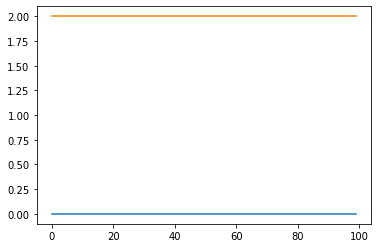

In [65]:
fig = plt.plot(tmp_x, label='~x"')
fig = plt.plot(tmp_y, label='~y"')
plt.show()

In [57]:
F

Matrix([
[-T*sin(alpha) + W*cos(alpha)],
[ T*cos(alpha) + W*sin(alpha)]])

## Проинтегрируем численно

In [27]:
left = []; right = []

In [28]:
left += S.left_part_Eqs(S.constraints)
right += S.right_part_Eqs(S.constraints)

In [29]:
diff_omegas_t = [Derivative(S.create_fs(x)) for x in S.right_part_Eqs(S.omega_equations)]
constr = solve(eqs, diff_omegas_t)
constr

{Derivative(nu1(t), t): (A*nu2(t)*nu3(t) - C*nu2(t)*nu3(t) + g*m*sin(theta)*cos(phi))/A,
 Derivative(nu2(t), t): (-A*nu1(t)*nu3(t) + C*nu1(t)*nu3(t) - g*m*sin(phi)*sin(theta))/A,
 Derivative(nu3(t), t): 0}

In [30]:
for left_item, right_item in constr.items():
    left += [left_item]
    right += [right_item]

In [31]:
_vars = (phi, psi, theta, nu1, nu2, nu3)

In [32]:
right = [S.create_ss(x) for x in right]

In [33]:
_subs = {A: 1, C: 2, g: 10, m: 1}

In [34]:
left

[Derivative(phi, t),
 Derivative(psi, t),
 Derivative(theta, t),
 Derivative(nu1(t), t),
 Derivative(nu2(t), t),
 Derivative(nu3(t), t)]

In [35]:
right

[-nu1*sin(phi)/tan(theta) - nu2*cos(phi)/tan(theta) + nu3,
 (nu1*sin(phi) + nu2*cos(phi))/sin(theta),
 nu1*cos(phi) - nu2*sin(phi),
 (A*nu2*nu3 - C*nu2*nu3 + g*m*sin(theta)*cos(phi))/A,
 (-A*nu1*nu3 + C*nu1*nu3 - g*m*sin(phi)*sin(theta))/A,
 0]

In [36]:
def f(_vars_values, time):
    return [lambdify(_vars, x.subs(_subs), 'numpy')(*_vars_values) for x in right]

In [47]:
f0 = [3,0.1,0.1,1,2,3]

In [48]:
import numpy as np
from scipy.integrate import RK45, odeint

In [49]:
_solution = odeint(f, f0, np.linspace(0., 4., 100))

phi


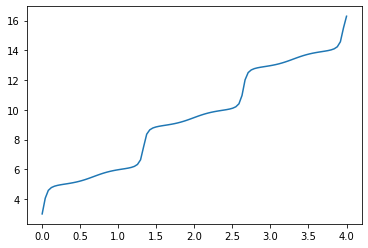

psi


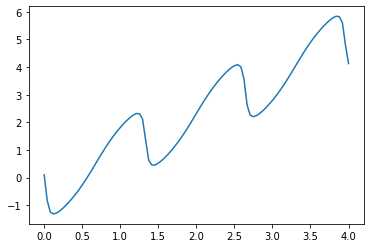

theta


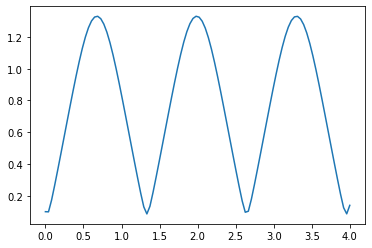

nu1


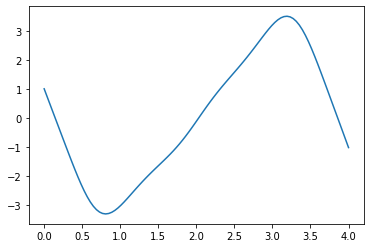

nu2


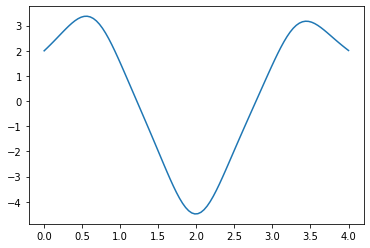

nu3


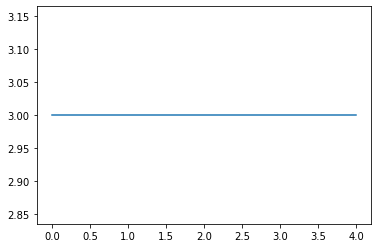

In [74]:
import matplotlib.pyplot as plt 

_items = zip(['phi', 'psi', 'theta', 'nu1', 'nu2', 'nu3'], list(range(6)))

for name, col in _items:
    print(name)
    fig = plt.plot(np.linspace(0,4,100), _solution[:, col], label=name)
    plt.show()

## Посмотрим на энергию

In [64]:
H = A*(Derivative(theta,t)**2 + Derivative(psi,t)**2*sin(theta)**2)/2 \
    + C*(Derivative(phi, t) + Derivative(psi, t)*cos(theta))**2/2 \
    + m*g*cos(theta)
H

A*(sin(theta)**2*Derivative(psi, t)**2 + Derivative(theta, t)**2)/2 + C*(cos(theta)*Derivative(psi, t) + Derivative(phi, t))**2/2 + g*m*cos(theta)

In [65]:
H = S.sub_constraints(H)
H

A*nu1**2/2 + A*nu2**2/2 + C*nu3**2/2 + g*m*cos(theta)

In [66]:
fH = lambdify(_vars, H.subs(_subs), 'numpy')

In [67]:
H_values = np.array([fH(*x) for x in _solution])
max(H_values) - min(H_values)

9.375154874646796e-07

In [68]:
for x in S.constraints:
    display(x)

Eq(Derivative(phi, t), -nu1*sin(phi)/tan(theta) - nu2*cos(phi)/tan(theta) + nu3)

Eq(Derivative(psi, t), (nu1*sin(phi) + nu2*cos(phi))/sin(theta))

Eq(Derivative(theta, t), nu1*cos(phi) - nu2*sin(phi))

In [69]:
L

Eq(L, A*(sin(theta)**2*Derivative(psi, t)**2 + Derivative(theta, t)**2)/2 + C*(cos(theta)*Derivative(psi, t) + Derivative(phi, t))**2/2 - g*m*cos(theta))

# $$ x(t), y(t), \alpha(t)$$

1. зададим $x(t), y(t), \alpha(t)$
2. 

In [76]:
S.

[Eq(Derivative(phi, t), -nu1*sin(phi)/tan(theta) - nu2*cos(phi)/tan(theta) + nu3),
 Eq(Derivative(psi, t), (nu1*sin(phi) + nu2*cos(phi))/sin(theta)),
 Eq(Derivative(theta, t), nu1*cos(phi) - nu2*sin(phi))]